In [1]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
path = "../data/raw_total_fight_data.csv"
df_total_fight_data = pd.read_csv(filepath_or_buffer=path, sep=';')
df_total_fight_data.shape

(5144, 41)

In [4]:
df_total_fight_data.head()

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,R_TD,B_TD,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,R_HEAD,B_HEAD,R_BODY,B_BODY,R_LEG,B_LEG,R_DISTANCE,B_DISTANCE,R_CLINCH,B_CLINCH,R_GROUND,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
0,Henry Cejudo,Marlon Moraes,0,0,90 of 171,57 of 119,52%,47%,99 of 182,59 of 121,1 of 4,0 of 2,25%,0%,1,0,1,0,0,0,73 of 150,35 of 89,13 of 16,7 of 8,4 of 5,15 of 22,45 of 118,54 of 116,19 of 23,2 of 2,26 of 30,1 of 1,KO/TKO,3,4:51,5 Rnd (5-5-5-5-5),Marc Goddard,"June 08, 2019","Chicago, Illinois, USA",UFC Bantamweight Title Bout,Henry Cejudo
1,Valentina Shevchenko,Jessica Eye,1,0,8 of 11,2 of 12,72%,16%,37 of 40,42 of 52,2 of 2,0 of 0,100%,0%,1,0,3,0,0,0,4 of 5,0 of 7,4 of 6,0 of 2,0 of 0,2 of 3,5 of 8,2 of 12,2 of 2,0 of 0,1 of 1,0 of 0,KO/TKO,2,0:26,5 Rnd (5-5-5-5-5),Robert Madrigal,"June 08, 2019","Chicago, Illinois, USA",UFC Women's Flyweight Title Bout,Valentina Shevchenko
2,Tony Ferguson,Donald Cerrone,0,0,104 of 200,68 of 185,52%,36%,104 of 200,68 of 185,0 of 0,1 of 1,0%,100%,0,0,0,0,0,0,65 of 144,43 of 152,25 of 37,15 of 23,14 of 19,10 of 10,103 of 198,68 of 184,1 of 2,0 of 1,0 of 0,0 of 0,TKO - Doctor's Stoppage,2,5:00,3 Rnd (5-5-5),Dan Miragliotta,"June 08, 2019","Chicago, Illinois, USA",Lightweight Bout,Tony Ferguson
3,Jimmie Rivera,Petr Yan,0,2,73 of 192,56 of 189,38%,29%,76 of 195,58 of 192,0 of 3,1 of 3,0%,33%,0,0,0,1,0,0,42 of 145,40 of 166,15 of 24,13 of 19,16 of 23,3 of 4,60 of 173,42 of 167,9 of 15,10 of 12,4 of 4,4 of 10,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Kevin MacDonald,"June 08, 2019","Chicago, Illinois, USA",Bantamweight Bout,Petr Yan
4,Tai Tuivasa,Blagoy Ivanov,0,1,64 of 144,73 of 123,44%,59%,66 of 146,81 of 131,0 of 0,2 of 2,0%,100%,0,0,0,0,0,0,39 of 114,65 of 114,6 of 7,7 of 8,19 of 23,1 of 1,50 of 126,62 of 111,14 of 18,5 of 6,0 of 0,6 of 6,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Dan Miragliotta,"June 08, 2019","Chicago, Illinois, USA",Heavyweight Bout,Blagoy Ivanov


In [5]:
datatypes = df_total_fight_data.dtypes
variables = df_total_fight_data.columns.tolist()

## Features to engineer

- Number of minutes fought per fight
- Location by country
- Date: try to engineer the day of the event to see it's importance
- Winner: Keep it as either RED or BLUE
- Weight class


## Features to drop

- R_DISTANCE
- B_DISTANCE
- Format
- Fight_type
- Referee ???

# Cleaning, Wrangling & Feature Engineering

In [6]:
def get_missing_values(df):
    """ Gets DataFrame of variables and number of values missing per variable """
    missing_value_count_column = 'missing_value_count'
    rename_dict = {
        'index': 'feature',
        0: missing_value_count_column,
        '0': missing_value_count_column
    }
    df_missing_values = df.isnull().sum().to_frame().reset_index()
    df_missing_values.rename(mapper=rename_dict, axis=1, inplace=True)
    df_missing_values.sort_values(by=missing_value_count_column, ascending=False, inplace=True)
    df_missing_values = df_missing_values[df_missing_values[missing_value_count_column] > 0].reset_index(drop=True)
    return df_missing_values

In [7]:
def get_landed(obj):
    obj = str(obj).strip().split('of') # Returns list of length 3
    landed = int(obj[0])
    return landed


def get_attempted(obj):
    obj = str(obj).strip().split('of') # Returns list of length 3
    attempted = int(obj[-1])
    return attempted


def add_landed_vs_attempted(df):
    df_temp = df.copy()
    features = ['R_KD', 'B_KD', 'R_TD', 'B_TD', 'R_HEAD', 'B_HEAD', 'R_BODY', 'B_BODY', 'R_LEG', 'B_LEG',
                'R_SIG_STR.', 'B_SIG_STR.', 'R_TOTAL_STR.', 'B_TOTAL_STR.', 'R_CLINCH', 'B_CLINCH',
                'R_GROUND', 'B_GROUND']
    for feature in features:
        new_feature_for_landed = feature + '_landed'
        df_temp[new_feature_for_landed] = df_temp[feature].apply(get_landed)
        new_feature_for_attempted = feature + '_attempted'
        df_temp[new_feature_for_attempted] = df_temp[feature].apply(get_attempted)
    df_temp.drop(labels=features, axis=1, inplace=True)
    return df_temp


def alter_percentages(obj):
    obj = str(obj)[:-1]
    obj = float(obj)
    return obj


def clean_percentages(df):
    df_temp = df.copy()
    features = ['R_SIG_STR_pct', 'B_SIG_STR_pct', 'R_TD_pct', 'B_TD_pct']
    for feature in features:
        df_temp[feature] = df_temp[feature].apply(alter_percentages)
    return df_temp

In [8]:
def extract_minutes(obj):
    """ Helper function """
    obj = str(obj).split(':')
    secs = int(obj[0]) * 60 + int(obj[-1])
    mins = round(secs / 60, 2)
    return mins


def get_fight_minutes(df):
    df_temp = df.copy()
    fight_mins = ((df_temp['last_round'] - 1) * 5) + df_temp['last_round_time'].apply(extract_minutes)
    df_temp['fight_mins'] = fight_mins
    return df_temp


def extract_country(obj):
    country = str(obj).split(',')[-1].strip().upper()
    return country


def alter_date(date_obj):
    month_mapper = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
        'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    mmdd, yy = str(date_obj).split(',')
    mm, dd = mmdd.split(' ')
    yy = str(yy).strip()
    dd = str(dd)
    mm = str(month_mapper[mm])
    final_date = pd.to_datetime("{}/{}/{}".format(mm, dd, yy))
    return final_date


def day_of_week(date):
    """
    Takes in Pandas datetime, and returns the name of day of that date.
    """
    day_index = date.weekday()
    day = calendar.day_name[day_index]
    return day


def winning_corner(df):
    df_temp = df.copy()
    mapper = {
        True: 'Red',
        False: 'Blue'
    }
    winner_series = (df_temp['R_fighter'] == df_temp['Winner']).map(mapper)
    return winner_series

In [9]:
def map_win_method(df):
    df_temp = df.copy()
    win_method_mapper = dict()
    win_methods = df_temp['win_by'].dropna().unique().tolist()
    for i, win_method in enumerate(win_methods):
        win_method_mapper[win_method] = i+1
    df_temp['Win_method'] = df_temp['win_by'].map(win_method_mapper)
    df_temp['Win_method'] = df_temp['Win_method'].astype(str)
    return df_temp


def map_day(df):
    df_temp = df.copy()
    day_mapper_dict = dict()
    days = df_temp['day_of_week'].dropna().unique().tolist()
    for i, day in enumerate(days):
        day_mapper_dict[day] = i+1
    df_temp['day_of_week'] = df_temp['day_of_week'].map(day_mapper_dict)
    return df_temp


def map_winner(df):
    df_temp = df.copy()
    winner_mapper_dict = dict()
    winners = df_temp['Winning_Corner'].dropna().unique().tolist()
    for i, winner in enumerate(winners):
        winner_mapper_dict[winner] = i
    df_temp['Winning_Corner'] = df_temp['Winning_Corner'].map(winner_mapper_dict)
    return df_temp


def map_country(df):
    df_temp = df.copy()
    country_mapper = dict()
    countries = df_temp['country'].dropna().unique().tolist()
    for i, country in enumerate(countries):
        country_mapper[country] = i
    df_temp['country'] = df_temp['country'].map(country_mapper)
    return df_temp

# Pipeline for Feature Engineering (Putting things together)

In [10]:
df_missing = get_missing_values(df=df_total_fight_data)
df_missing

,feature,missing_value_count
0,Winner,83
1,Referee,23


In [11]:
def feature_engineering_pipeline(df_raw):
    df_raw.dropna(inplace=True)
    df_features = add_landed_vs_attempted(df=df_raw)
    df_features = clean_percentages(df=df_features)
    df_features = get_fight_minutes(df=df_features)
    df_features['country'] = df_features['location'].apply(extract_country)

    df_features['date_dt'] = df_features['date'].apply(alter_date)
    df_features['day_of_week'] = df_features['date_dt'].apply(day_of_week)
    df_features['Winning_Corner'] = winning_corner(df=df_features)
    df_features = map_win_method(df=df_features)

    feats_to_drop = ['R_DISTANCE', 'B_DISTANCE', 'Format', 'Fight_type', 'Referee', 'win_by', 'last_round',
                     'last_round_time', 'date', 'location', 'Winner', 'date_dt']
    if feats_to_drop:
        df_features.drop(labels=feats_to_drop, axis=1, inplace=True)

    df_features = map_day(df=df_features)
    df_features = map_winner(df=df_features)
    df_features = map_country(df=df_features)
    return df_features

In [12]:
def convert_to_categorical(df):
    """ Takes in DataFrame of features and converts required columns into categorical variables """
    df_temp = df.copy()
    categorical_variables = ['country', 'day_of_week', 'Win_method']
    for categorical_variable in categorical_variables:
        df_temp[categorical_variable] = df_temp[categorical_variable].astype('category')
    return df_temp

In [13]:
%%time

path = "../data/raw_total_fight_data.csv"
df_total_fight_data = pd.read_csv(filepath_or_buffer=path, sep=';')
df_examples = feature_engineering_pipeline(df_raw=df_total_fight_data)
# df_examples = convert_to_categorical(df=df_examples)

Wall time: 1.32 s


In [14]:
df_examples.head()

,R_fighter,B_fighter,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,R_PASS,B_PASS,R_REV,B_REV,R_KD_landed,R_KD_attempted,B_KD_landed,B_KD_attempted,R_TD_landed,R_TD_attempted,B_TD_landed,B_TD_attempted,R_HEAD_landed,R_HEAD_attempted,B_HEAD_landed,B_HEAD_attempted,R_BODY_landed,R_BODY_attempted,B_BODY_landed,B_BODY_attempted,R_LEG_landed,R_LEG_attempted,B_LEG_landed,B_LEG_attempted,R_SIG_STR._landed,R_SIG_STR._attempted,B_SIG_STR._landed,B_SIG_STR._attempted,R_TOTAL_STR._landed,R_TOTAL_STR._attempted,B_TOTAL_STR._landed,B_TOTAL_STR._attempted,R_CLINCH_landed,R_CLINCH_attempted,B_CLINCH_landed,B_CLINCH_attempted,R_GROUND_landed,R_GROUND_attempted,B_GROUND_landed,B_GROUND_attempted,fight_mins,country,day_of_week,Winning_Corner,Win_method
0,Henry Cejudo,Marlon Moraes,52.0,47.0,25.0,0.0,1,0,1,0,0,0,0,0,0,0,1,4,0,2,73,150,35,89,13,16,7,8,4,5,15,22,90,171,57,119,99,182,59,121,19,23,2,2,26,30,1,1,14.85,0,1,0,1
1,Valentina Shevchenko,Jessica Eye,72.0,16.0,100.0,0.0,1,0,3,0,0,0,1,1,0,0,2,2,0,0,4,5,0,7,4,6,0,2,0,0,2,3,8,11,2,12,37,40,42,52,2,2,0,0,1,1,0,0,5.43,0,1,0,1
2,Tony Ferguson,Donald Cerrone,52.0,36.0,0.0,100.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,65,144,43,152,25,37,15,23,14,19,10,10,104,200,68,185,104,200,68,185,1,2,0,1,0,0,0,0,10.00,0,1,0,2
3,Jimmie Rivera,Petr Yan,38.0,29.0,0.0,33.0,0,0,0,1,0,0,0,0,2,2,0,3,1,3,42,145,40,166,15,24,13,19,16,23,3,4,73,192,56,189,76,195,58,192,9,15,10,12,4,4,4,10,15.00,0,1,1,3
4,Tai Tuivasa,Blagoy Ivanov,44.0,59.0,0.0,100.0,0,0,0,0,0,0,0,0,1,1,0,0,2,2,39,114,65,114,6,7,7,8,19,23,1,1,64,144,73,123,66,146,81,131,14,18,5,6,0,0,6,6,15.00,0,1,1,3


In [15]:
df_examples.dtypes

R_fighter                  object
B_fighter                  object
R_SIG_STR_pct             float64
B_SIG_STR_pct             float64
R_TD_pct                  float64
B_TD_pct                  float64
R_SUB_ATT                   int64
B_SUB_ATT                   int64
R_PASS                      int64
B_PASS                      int64
R_REV                       int64
B_REV                       int64
R_KD_landed                 int64
R_KD_attempted              int64
B_KD_landed                 int64
B_KD_attempted              int64
R_TD_landed                 int64
R_TD_attempted              int64
B_TD_landed                 int64
B_TD_attempted              int64
R_HEAD_landed               int64
R_HEAD_attempted            int64
B_HEAD_landed               int64
B_HEAD_attempted            int64
R_BODY_landed               int64
R_BODY_attempted            int64
B_BODY_landed               int64
B_BODY_attempted            int64
R_LEG_landed                int64
R_LEG_attempte

# Feature Selection & Modeling

In [16]:
if df_examples.isnull().sum().sum() == 0:
    print("No missing values!")
else:
    print("There are missing values!")

No missing values!


### The `country` column has too many categories. Let's drop it!

In [ ]:
# X = df_examples.drop(labels=['R_fighter', 'B_fighter', 'Winning_Corner'], axis=1)
# y = df_examples['Winning_Corner'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# # Feature Scaling
# sc_X = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.transform(X_test)

# # Fitting Classifier to Training set
# classifier = KNeighborsClassifier(n_neighbors = 10, metric='minkowski', p=2)
# classifier.fit(X_train, y_train)


# # Predicting test set results
# y_pred = classifier.predict(X_test)

# # Making a Confusion Matrix, containing correct & incorrect predictions
# cm = confusion_matrix(y_test, y_pred)

# model_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred, normalize=True) * 100
# model_accuracy = round(model_accuracy, 2)
# model_accuracy

In [17]:
df_examples.drop(labels=['country'], axis=1, inplace=True)

# Modeling


### Let's try few different classifiers and compare scores

- Random Forest
- KNN
- Logistic Regression
- Support Vector Machine
- Kernel SVM
- Naive Bayes


- Any ensemble technique

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, naive_bayes
from sklearn.metrics import confusion_matrix, accuracy_score

In [39]:
import joblib

In [ ]:
# filename = "model.pkl"
# joblib.dump(value=model_obj, filename=filename)

# joblib.load(filename=filename)

In [ ]:
# def get_model(df_feats):
#     df_fts = df_feats.copy()
#     X = df_fts.drop(labels=['R_fighter', 'B_fighter', 'Winning_Corner'], axis=1)
#     y = df_fts['Winning_Corner'].values
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=0)
    
#     # Feature Scaling
#     sc_X = StandardScaler()
#     X_train = sc_X.fit_transform(X_train)
#     X_test = sc_X.transform(X_test)
    
#     # Fitting Classifier to Training set
#     classifier = KNeighborsClassifier(n_neighbors=15, metric='minkowski', p=2)
#     model_obj = classifier.fit(X_train, y_train)
#     return X_train, X_test, y_train, y_test, model_obj

In [46]:
df_fts = df_examples.copy()
X = df_fts.drop(labels=['R_fighter', 'B_fighter', 'Winning_Corner'], axis=1)
y = df_fts['Winning_Corner'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=0)

# Feature Scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting Classifier to Training set
algorithms = ['knn', 'rfc', 'logistic_regression', 'svm', 'naive_bayes']
algorithm = 'knn'

if algorithm == 'knn':
    classifier = KNeighborsClassifier(n_neighbors=55, metric='minkowski', p=2)
elif algorithm == 'rfc':
    classifier = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=30, oob_score_=True)
elif algorithm == 'logistic_regression':
    classifier = LogisticRegression(solver='sag')
elif algorithm == 'svm':
    classifier = svm.SVC(kernel='rbf')
elif algorithm == 'naive_bayes':
    classifier = naive_bayes.GaussianNB()

model = classifier.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [47]:
model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=55, p=2,
           weights='uniform')

In [48]:
# X_train, X_test, y_train, y_test, model = get_model(df_feats=df_examples)
# print("Model type: {}".format(type(model)))

# Predicting test set results
y_pred = model.predict(X_test)

# Making a Confusion Matrix, containing correct & incorrect predictions
cm = confusion_matrix(y_test, y_pred)

# Get model accuracy
model_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred, normalize=True) * 100
model_accuracy = round(model_accuracy, 2)

print(f"cm: {cm}")
print(f"model_accuracy: {model_accuracy}")

cm: [[711  48]
 [106 244]]
model_accuracy: 86.11


### K-fold Cross-validation

In [21]:
X = df_examples.drop(labels=['R_fighter', 'B_fighter', 'Winning_Corner'], axis=1)
y = df_examples['Winning_Corner'].values

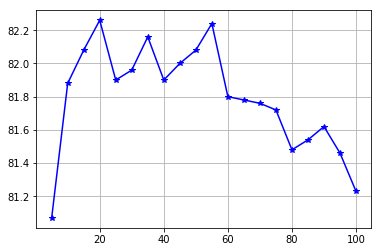

Wall time: 18.5 s


In [22]:
%%time

start, stop = 5, 100
k_range = np.arange(start=start, stop=stop+1, step=5)
scores = list()
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    score = cross_val_score(estimator=knn, X=X, y=y, cv=10, scoring='accuracy')
    scores.append(score.mean())

df_accuracies = pd.DataFrame({
    'k_value': k_range,
    'accuracy_score': scores
})
df_accuracies['accuracy_score'] = df_accuracies['accuracy_score'] * 100
df_accuracies['accuracy_score'] = df_accuracies['accuracy_score'].apply(round, args=[2])

plt.plot(df_accuracies['k_value'], df_accuracies['accuracy_score'], color='blue', marker='*')
plt.grid()
plt.show()

In [23]:
knn = KNeighborsClassifier(n_neighbors=55, metric='minkowski', p=2)
score = cross_val_score(estimator=knn, X=X, y=y, cv=10, scoring='accuracy')
score.mean()

0.8223867114771688

In [38]:
logreg = LogisticRegression(solver='sag')
score = cross_val_score(estimator=logreg, X=X, y=y, cv=10, scoring='accuracy')
score.mean()

D:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\An

0.8481862791504937

In [26]:
rf_clf = RandomForestClassifier(n_estimators=30, max_depth=30, n_jobs=-1)
score = cross_val_score(estimator=rf_clf, X=X, y=y, cv=10, scoring='accuracy')
score.mean()

0.8795441635898891

### Hyperparameter tuning

In [35]:
def rf_feat_importance(model, df):
    feat_importance_data = {
        'Feature': df.columns,
        'Importance': model.feature_importances_
    }
    df_feat_importances = pd.DataFrame(data=feat_importance_data).sort_values('Importance', ascending=False)
    return df_feat_importances

In [36]:
rf_clf = RandomForestClassifier(n_estimators=30, max_depth=30, n_jobs=-1)
model_obj = rf_clf.fit(X_train, y_train)

fi = rf_feat_importance(model=model_obj, df=X)
fi['Importance'] = fi['Importance'] * 100
fi['Importance'] = fi['Importance'].apply(round, args=[2])

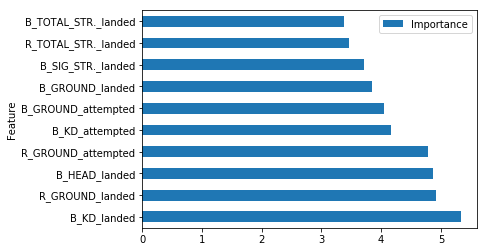

In [49]:
fi.set_index(keys='Feature').head(10).plot(kind='barh')
plt.show()

### Further validation